In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os 
import random
import numpy as np
import scipy.stats as stats
from skimage.segmentation import slic
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imagenet_path = './imagenet_samples'
image_paths = [os.path.join(imagenet_path, image_path) for image_path in os.listdir(imagenet_path) if image_path.endswith(('jpeg', 'JPEG'))]

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True).to(device)
model.eval()  # Set model to evaluation mode

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]   
    )
])

# Load the ImageNet class index mapping
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}


def get_image_batch(image):
    tensor = preprocess(image)
    batch = tensor.unsqueeze(0).to(device)
    return batch

def LIME(image, target_class):
    kernel_size = 0.25
    K = 30
    def generate_mask_images(image):
        image = np.array(image)
        # segments = slic(image)
        segments = slic(image, n_segments=100)
        segments_num = len(np.unique(segments))
        
        mask_images = []
        binary_masks = []
        
        # iterate numbers
        for _ in range(2000):
            mask_image = image.copy()
            segments_mask = [random.choice([0, 1]) for _ in range(segments_num)]
            
            for segment_id in range(segments_num):
                if segments_mask[segment_id] == 0:
                    pixels_mask = (segments == segment_id)
                    # mask_image[pixels_mask] = 127
                    mask_image[pixels_mask] = 255
                    # mask_image[pixels_mask] = 0
            
            mask_images.append(mask_image)
            binary_masks.append(segments_mask)
            
        return np.array(mask_images), np.array(binary_masks), segments
    
    def get_predictions(mask_images, model):
        predictions = []
        for mask_image in mask_images:
            perturbed_PIL_image = Image.fromarray(mask_image.astype('uint8'))
            input_batch = get_image_batch(perturbed_PIL_image)
            
            with torch.no_grad():
                output = model(input_batch)
                prediction = torch.softmax(output, dim=1)
            predictions.append(prediction.cpu().numpy()[0])
            
        return np.array(predictions)

    def get_weights(binary_masks, kernel_size):
        distances = pairwise_distances(
            binary_masks,
            binary_masks[0].reshape(1, -1),
            metric='cosine'
        ).ravel()
        weights = np.exp(-(distances ** 2) / kernel_size ** 2)
        return weights

    mask_images, binary_masks, segments = generate_mask_images(image)
    predictions = get_predictions(mask_images, model)
    weights = get_weights(binary_masks, kernel_size)

    lasso = Lasso(alpha=0.0005)
    lasso.fit(binary_masks, predictions[ : , target_class], sample_weight=weights)

    coef = np.abs(lasso.coef_)
    k_features = np.argsort(coef)[-K : ]

    results = np.zeros(np.array(image).shape[ : 2])
    for segment_id in k_features:
        mask = (segments == segment_id)
        results[mask] = lasso.coef_[segment_id]
    
    return results

def smoothgrad(input_batch, target_class):
    noise_num = 0.1
    sample_num = 300
    # input_batch = get_image_batch(image)

    total_gradients = torch.zeros_like(input_batch)
    for _ in range(sample_num):
        noise = torch.normal(0, noise_num, input_batch.shape).to(input_batch.device)
        noisy_image = input_batch.clone() + noise
        noisy_image_copy = noisy_image.clone().detach().requires_grad_(True)
        if noisy_image_copy.grad is not None:
            noisy_image_copy.grad.zero_()
        
        output = model(noisy_image_copy)
        score = output[0][target_class]
        
        model.zero_grad()
        score.backward()
        
        gradients = noisy_image_copy.grad.detach()
        
        total_gradients += gradients
        
    smooth_gradients = total_gradients / sample_num

    results = torch.sum(torch.abs(smooth_gradients), dim=1).squeeze()
    return results

def visualize_explanation(image, explanation):
    plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(explanation)
    plt.title('Results')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# for image_path in image_paths:
#     image = Image.open(image_path).convert('RGB')
#     input_batch = get_image_batch(image)

#     with torch.no_grad():
#         output = model(input_batch)
#     _, predict_index = torch.max(output, 1)
#     predict_index = predict_index.item()
    
#     lime_results = LIME(image, predict_index)
#     smoothgrad_results = smoothgrad(image, predict_index)
    
#     visualize_explanation(image, lime_results)
#     visualize_explanation(image, smoothgrad_results)

#     print(image_path)
#     print(idx2label[predict_index])
#     print()

#     smoothgrad_results = np.resize(smoothgrad_results, lime_results.shape)
#     lime_normalize = (lime_results - lime_results.min()) / (lime_results.max() - lime_results.min())
#     smoothgrad_normalize = (smoothgrad_results - smoothgrad_results.min()) / (smoothgrad_results.max() - smoothgrad_results.min())
#     kendall_tau, _ = stats.kendalltau(lime_normalize.flatten(), smoothgrad_normalize.flatten())
#     spearman, _ = stats.spearmanr(lime_normalize.flatten(), smoothgrad_normalize.flatten())
#     print(kendall_tau)
#     print(spearman)

c:\Users\wctsai\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wctsai\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, y, eps, targeted=False):
    # Notes: put the model in eval() mode for this function

    model.eval()
    x = x.clone().detach().to(device)
    x.requires_grad = True

    output = model(x)
    loss = criterion(output, y)

    model.zero_grad()
    loss.backward()
    
    gradient = x.grad.data
    sign_gradient = torch.sign(gradient)

    if targeted:
        adv = x - eps * sign_gradient
    else:
        adv = x + eps * sign_gradient
    adv = torch.clamp(adv, 0, 1)

    return adv
    

def pgd_untargeted(model, x, y, k, eps, eps_step):
    # Notes: put the model in eval() mode for this function
    # x: input image
    # y: ground truth label for x
    # k: steps of FGSM
    # eps: projection region for PGD (note the need for normalization before projection, as eps values are for inputs in [0,1])
    # eps_step: step for one iteration of FGSM
    model.eval()

    tempt = x.clone().detach()
    tempt.requires_grad = True

    for _ in range(k):
        tempt = fgsm(model, tempt, y, eps_step)
        tempt = torch.clamp(tempt, x - eps, x + eps)
        tempt = torch.clamp(tempt, 0, 1)

    return tempt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def attack_smoothgrad(model, image_tensor, target_class, normal_smoothgrad_results, eps):
    model.eval()
    
    image_tensor = image_tensor.to(device)
    noise_image = image_tensor.clone().detach().to(device)
    noise_image.requires_grad = True

    target = torch.tensor([target_class], dtype=torch.long, device=device)
    weight1, weight2 = 0.001, 0.999
    
    for _ in range(5):
        if noise_image.grad is not None:
            noise_image.grad.zero_()
        
        # noise_tempt = noise_image.unsqueeze(0).to(device)
        noise_input_batch = noise_image.unsqueeze(0).to(device)
        # noise_input_batch = fgsm(model, noise_tempt, target, eps, targeted=False)
        # print('noise_input_batch.shape : ', noise_input_batch.shape)
        # print('target.shape : ', target.shape)

        noise_prediction = model(noise_input_batch)

        # tempt = Image.fromarray(noise_image.permute(1, 2, 0).byte().cpu().numpy())
        # attack_smoothgrad_results = smoothgrad(tempt, target_class)
        attack_smoothgrad_results = smoothgrad(noise_input_batch, target_class)
        
        ce_loss = criterion(noise_prediction, target)
        mse_loss = -torch.mean((attack_smoothgrad_results - normal_smoothgrad_results) ** 2)
        total_loss = weight1 * ce_loss + weight2 * mse_loss
        # total_loss = ce_loss + 10 * (ce_loss.item() / mse_loss.item()) * mse_loss
        # print('ce_loss : ', ce_loss.item())
        # print('mse_loss : ', mse_loss.item())
        # print('total_loss : ', total_loss.item())
        
        total_loss.backward()

        # print(noise_image.device)
        # print(image_tensor.device)
        noise_image.data = torch.clamp(noise_image, image_tensor - eps, image_tensor + eps)
        noise_image.data = torch.clamp(noise_image, 0, 1)

    return noise_image.cpu().detach()

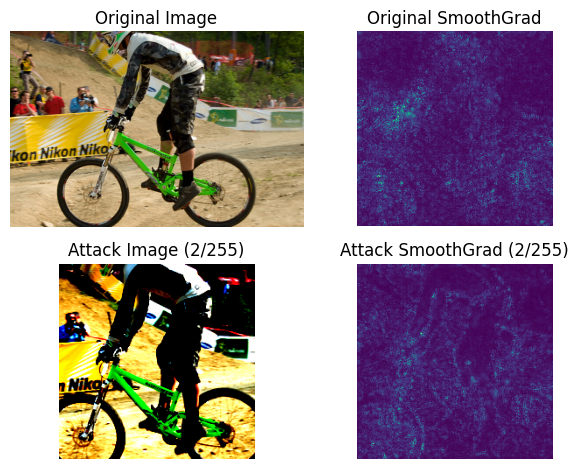

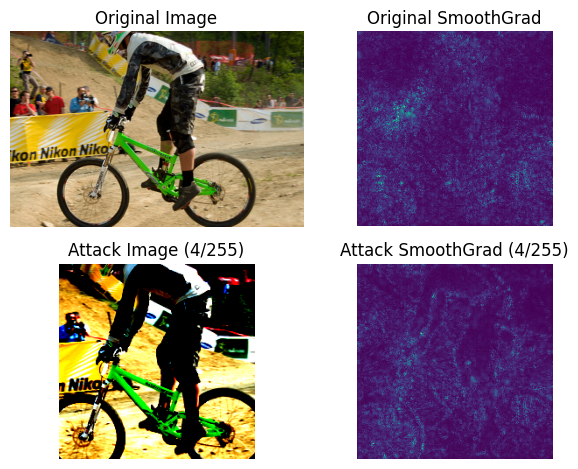

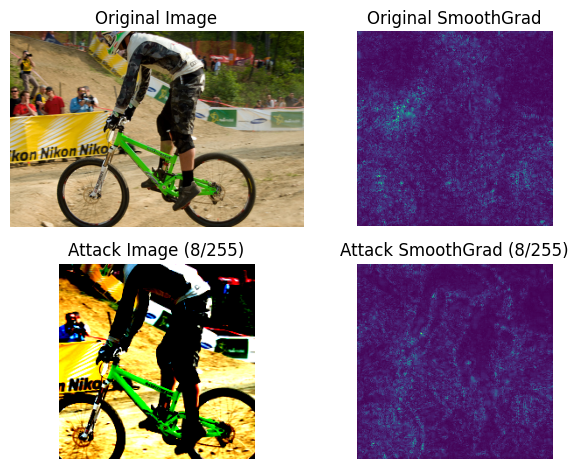

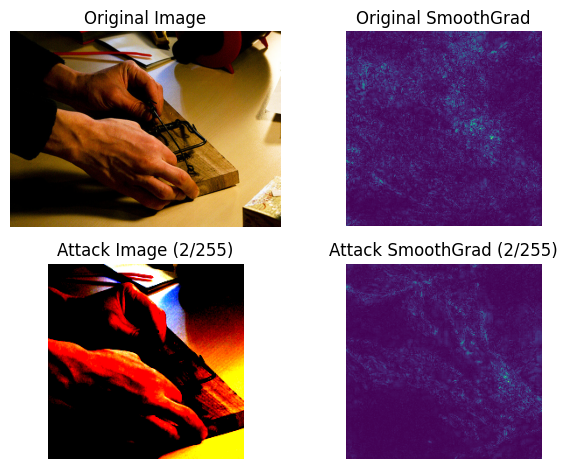

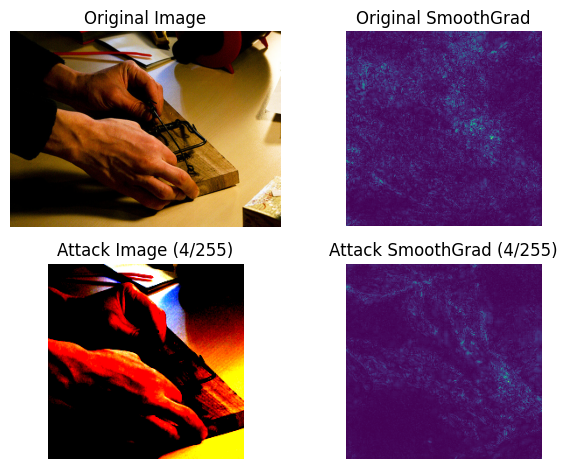

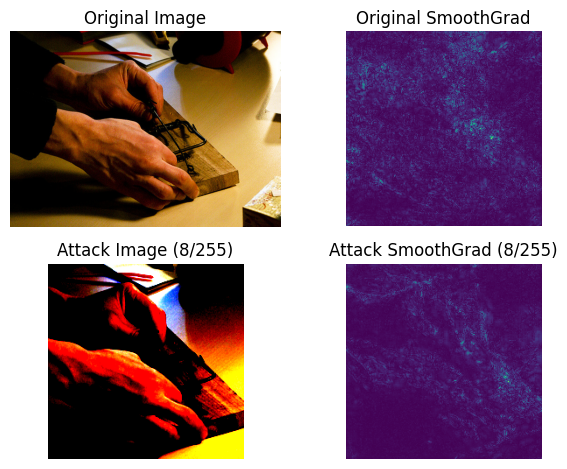

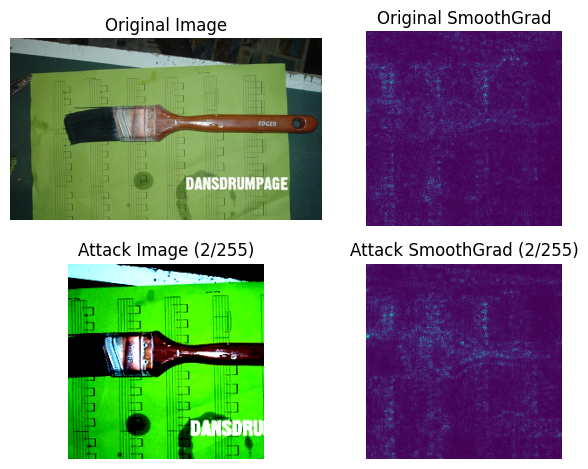

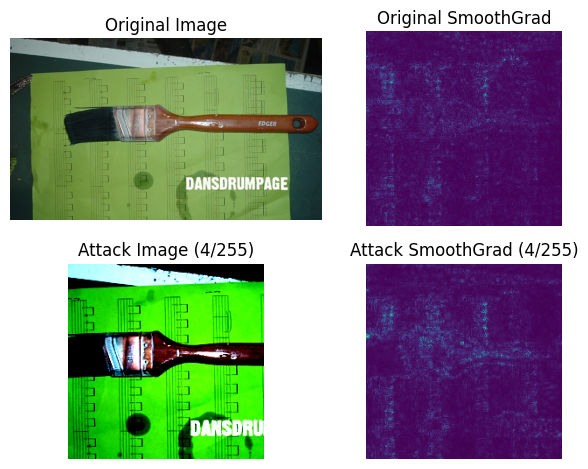

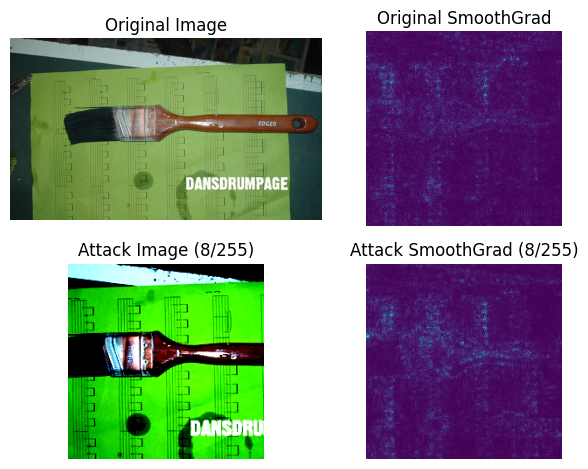

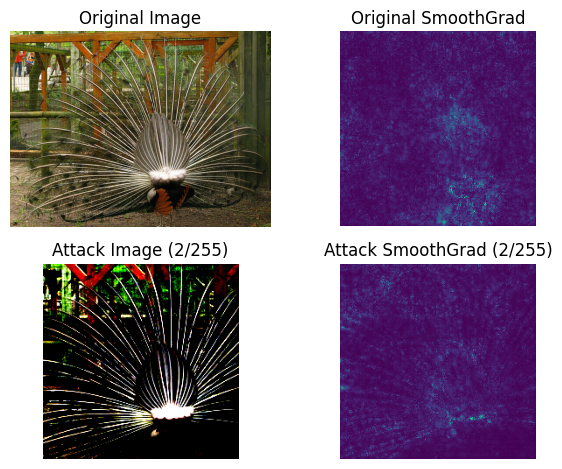

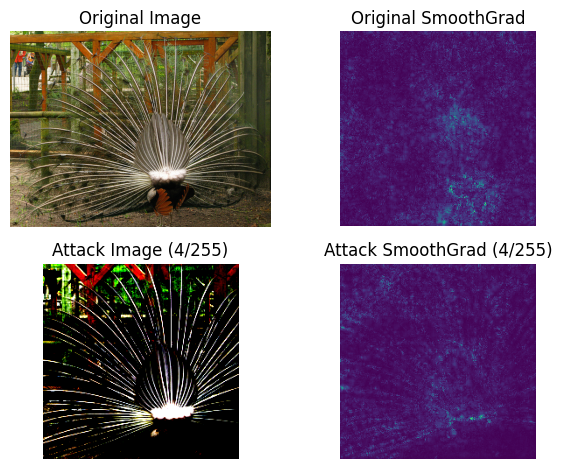

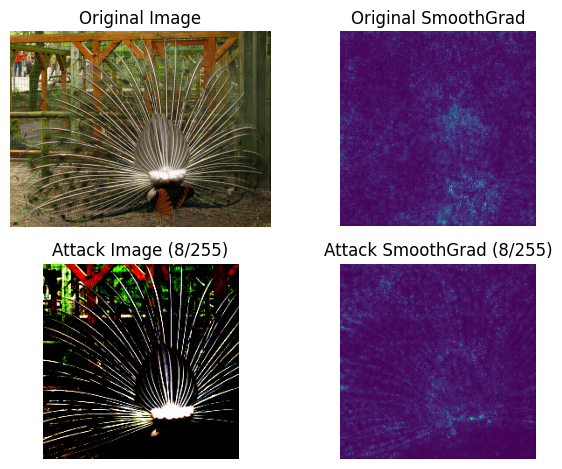

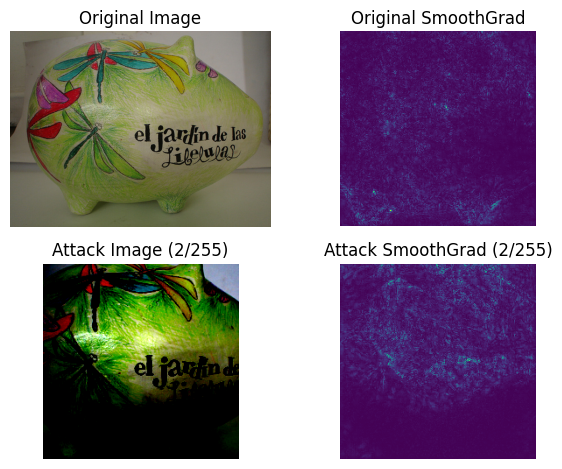

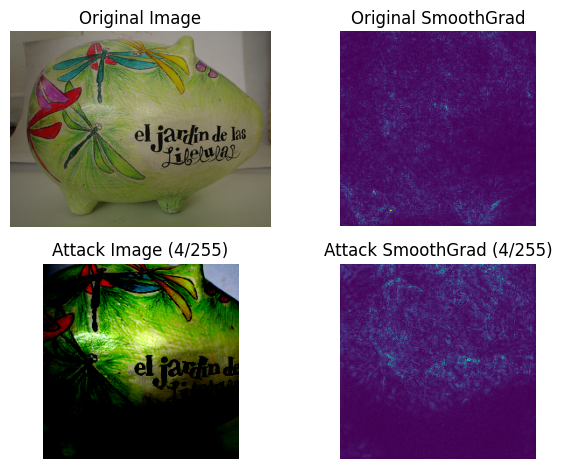

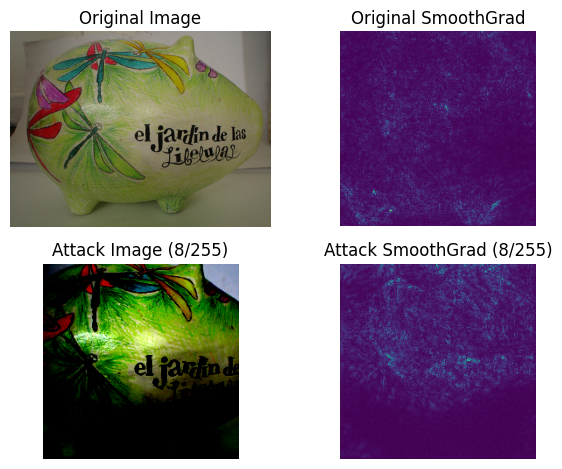

In [4]:
for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image)
    input_batch = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_batch)
        target_class = torch.argmax(output, dim=1).item()
    # print(idx2label[target_class])

    # normal_smoothgrad_results = smoothgrad(image, target_class)
    normal_smoothgrad_results = smoothgrad(input_batch, target_class)

    epsilons = [2/255, 4/255, 8/255]
    epsilons_string = ['2/255', '4/255', '8/255']
    for epsilon, epsilon_string in zip(epsilons, epsilons_string):
        noise_image = attack_smoothgrad(model, image_tensor, target_class, normal_smoothgrad_results, epsilon)
        noise_input_batch = noise_image.unsqueeze(0).to(device)
        
        # attack_smoothgrad_results = smoothgrad(Image.fromarray(noise_image.permute(1, 2, 0).byte().cpu().numpy()), target_class)
        attack_smoothgrad_results = smoothgrad(noise_input_batch, target_class)
        with torch.no_grad():
            noise_output = model(noise_input_batch)
            noise_output_class = torch.argmax(noise_output, dim=1).item()
        # print(idx2label[noise_output_class])

        plt.subplot(2, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(2, 2, 2)
        plt.imshow(normal_smoothgrad_results.detach().cpu().numpy())
        plt.title('Original SmoothGrad')
        plt.axis('off')
        
        plt.subplot(2, 2, 3)
        perturbed_image_np = noise_image.permute(1, 2, 0).cpu().numpy()
        plt.imshow(perturbed_image_np)
        plt.title(f'Attack Image ({epsilon_string})')
        plt.axis('off')
        
        plt.subplot(2, 2, 4)
        plt.imshow(attack_smoothgrad_results.detach().cpu().numpy())
        plt.title(f'Attack SmoothGrad ({epsilon_string})')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()